# Análise de sentimento de texto

Por sentimento, refiro-me a um valor quantitativo (no nível do intervalo) entre -1 e 1.

*   Se a pontuação de sentimento de um pedaço de texto estiver próxima de -1, diz-se que ele tem sentimento negativo.

*   Se a pontuação de sentimento estiver próxima de 1, diz-se que o texto tem um sentimento positivo.

*   Se a pontuação de sentimento estiver próxima de 0, dizemos que ele tem sentimento neutro.


In [1]:
# instalando pacotes necessários
#!pip install yfinance

In [1]:
# Importando bibliotecas
from google.colab import drive
from textblob import TextBlob   #Para análise de sentimento de um texto
import yfinance as yf
import datetime
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Função que retorna um sentimento de sentença
def stringToSentiment(texto):
    return TextBlob(texto).sentiment.polarity

In [3]:
#Vou testar alguns exemplos
stringToSentiment('I Love')

0.5

In [4]:
stringToSentiment('I Hate')

-0.8

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Agora vamos importar um arquivo csv para nosso estudo:
#Os dados são tweets de maio de 2015 e são sobre a Apple (AAPL)
tweets = pd.read_csv('/content/drive/My Drive/so_many_tweets.csv')
tweets.head()

,Text,Date,Status,Retweet
0,RT @j_o_h_n_danger: $TWTR now top holding for ...,2015-05-24 03:46:08,602319644234395648,6.022899e+17
1,RT diggingplatinum RT WWalkerWW: iOS 9 vs. And...,2015-05-24 04:17:42,602327586983796737,NaN
2,RT bosocial RT insidermonkey RT j_o_h_n_danger...,2015-05-24 04:13:22,602326499534966784,NaN
3,RT @WWalkerWW: iOS 9 vs. Android M – The New F...,2015-05-24 04:08:34,602325288740114432,6.023104e+17
4,RT @seeitmarket: Apple Chart Update: Big Test ...,2015-05-24 04:04:42,602324318903771136,6.023215e+17


No nosso DF temos as seguintes informações:

• Texto: texto não estruturado no nível nominal

• Date: Datetime (vamos pensar em datetime de forma contínua)

• Status: ID exclusivo do status no nível nominal

• Retweet: ID de status do tweet de que este tweet foi um retweet no nível nominal

In [7]:
# Col. Sentimento que receba "stringToSentiment" para a coluna de texto.
tweets['sentiment'] = tweets['Text'].apply(stringToSentiment)

In [8]:
#Vamos ver como ficou a nossa coluna de sentimento!
tweets.head()

,Text,Date,Status,Retweet,sentiment
0,RT @j_o_h_n_danger: $TWTR now top holding for ...,2015-05-24 03:46:08,602319644234395648,6.022899e+17,0.500000
1,RT diggingplatinum RT WWalkerWW: iOS 9 vs. And...,2015-05-24 04:17:42,602327586983796737,NaN,0.136364
2,RT bosocial RT insidermonkey RT j_o_h_n_danger...,2015-05-24 04:13:22,602326499534966784,NaN,0.500000
3,RT @WWalkerWW: iOS 9 vs. Android M – The New F...,2015-05-24 04:08:34,602325288740114432,6.023104e+17,0.136364
4,RT @seeitmarket: Apple Chart Update: Big Test ...,2015-05-24 04:04:42,602324318903771136,6.023215e+17,0.000000


Temos uma noção da pontuação de sentimento de cada tweet do conjunto de dados.

Vamos usar um dia de tweets para prever a movimentação de APPL em 24 horas.

A coluna Data revela vários tweets para cada dia.

Reamostraremos esses dados para avaliar o sentimento médio da ação no Twitter.

In [9]:
#Um Dataframe usará inteiros incrementais para as linhas (0 = 1° linha, 1 = 2°, etc).
tweets.index = pd.RangeIndex(start=0, stop=52512, step=1) #Criando o indíce
list(tweets.index)[:5]                                    #Verificando o indice

[0, 1, 2, 3, 4]

1. Garantiremos que a coluna Date seja do tipo Python datetime.

In [10]:
# converte a coluna de data como data e hora
tweets['Date'] = pd.to_datetime(tweets.Date)

2. Vamos substituir o índice do nosso Dataframe pela coluna datetime (que nos permite usar funções complexas de data/hora).

In [11]:
#Atribuir ao indíce do Dataframe os dados Datetime
tweets.index = tweets.Date

 3. Reamostraremos os dados para que cada linha represente um único dia com uma pontuação de sentimento agregada para cada dia:

In [12]:
# cria um dataframe chamado daily_tweets que reamostra os tweets por Dia, calculando a média das colunas
daily_tweets = tweets[['sentiment']].resample('D').agg('mean')
daily_tweets.head() # Quero apenas a coluna de sentimento em meu novo Dataframe.

,sentiment
Date,
2015-05-02,0.083031
2015-05-03,0.107045
2015-05-04,0.084062
2015-05-05,0.063895
2015-05-06,0.067004


Agora temos a coluna do dia e o sentimento médio para o dia.

In [13]:
#Ver quantas linhas tínhamos do nosso agrupamento
tweets.shape

(52512, 5)

In [14]:
#Ver o resultado do nosso agrupamento
daily_tweets.shape

(23, 1)

Passamos mais de 50.000 tweets para apenas 23 dias!

Vamos dar uma olhada na progressão do sentimento ao longo de vários dias

<Axes: xlabel='Date'>

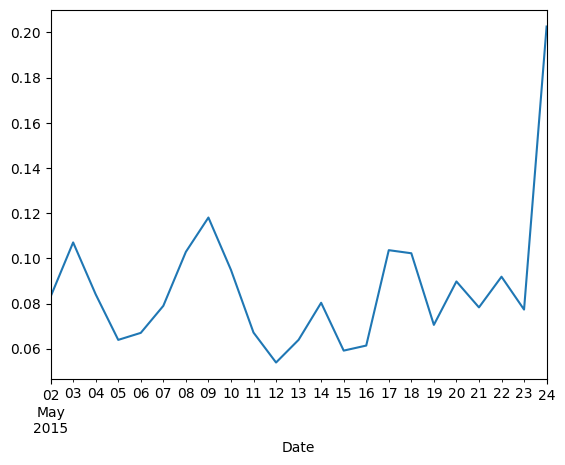

In [15]:
# plota o sentimento como um gráfico de linha ao longo dos 23 dias
daily_tweets.sentiment.plot(kind='line')

In [16]:
# Vamos analisar a influencia do sentimento com a movimentação da ação
# A partir disso vamos criar um modelo de regressão
inicio = '2015-05-02'
fim = '2015-05-25'
historical_prices = yf.download('AAPL', start=inicio, end=fim)
prices = pd.DataFrame(historical_prices)
prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-04,32.375000,32.642502,32.064999,32.174999,28.992023,203953200
2015-05-05,32.037498,32.112499,31.445000,31.450001,28.338755,197085600
2015-05-06,31.639999,31.687500,30.840000,31.252501,28.160789,288564000
2015-05-07,31.192499,31.520000,31.004999,31.315001,28.334969,175763600
2015-05-08,31.670000,31.905001,31.527500,31.905001,28.868822,222201600


Agora duas coisas:

• Queremos a coluna Close, é o preço final definido para o dia de negociação.

• Precisamos definir o índice deste Dataframe como data e hora para que possamos mesclar o sentimento e o preço Dataframes juntos.

In [17]:
#Novo DataFrame das linhas do Df prices onde o valor da coluna "Close" não é nulo.
not_null_close = prices[prices.Close.notnull()]
not_null_close.Volume = not_null_close.Volume.astype('int')
not_null_close.Close = not_null_close.Close.astype('float')
not_null_close.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-04,32.375000,32.642502,32.064999,32.174999,28.992023,203953200
2015-05-05,32.037498,32.112499,31.445000,31.450001,28.338755,197085600
2015-05-06,31.639999,31.687500,30.840000,31.252501,28.160789,288564000
2015-05-07,31.192499,31.520000,31.004999,31.315001,28.334969,175763600
2015-05-08,31.670000,31.905001,31.527500,31.905001,28.868822,222201600


In [18]:
not_null_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2015-05-04 to 2015-05-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       15 non-null     float64
 1   High       15 non-null     float64
 2   Low        15 non-null     float64
 3   Close      15 non-null     float64
 4   Adj Close  15 non-null     float64
 5   Volume     15 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 840.0 bytes


<Axes: xlabel='Date'>

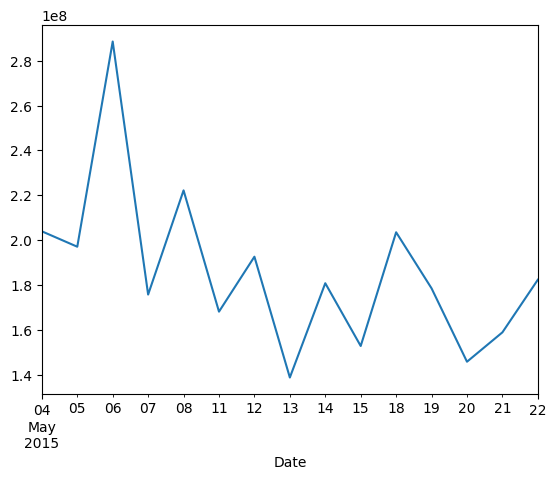

In [19]:
#Cria gráfico das colunas "Volume" x "Close" do DF not_null_close.
not_null_close['Volume'].plot()

In [20]:
# Retorna um resumo estatístico das colunas "Volume" e "Close" do Df prices.
prices[["Volume", 'Close']].describe()

,Volume,Close
count,1.500000e+01,15.000000
mean,1.859976e+08,32.042667
std,3.666822e+07,0.596598
min,1.387768e+08,31.252501
25%,1.635324e+08,31.485001
50%,1.808140e+08,32.174999
75%,2.003086e+08,32.516251
max,2.885640e+08,33.134998


A coluna Volume tem uma média de dezenas de milhões, enquanto o preço médio de fechamento é de apenas 33!

<Axes: >

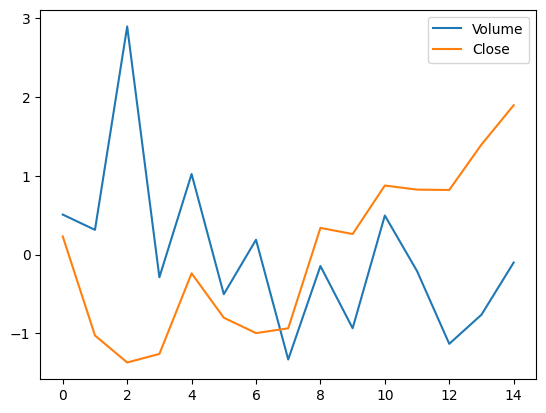

In [21]:
#Para treinamento e a aplicação de modelos de aprendizado de máquina
# dimensiona as colunas por pontuações z usando StandardScaler
from sklearn.preprocessing import StandardScaler

# Instância do StandardScaler para realizar a padronização dos dados.
s = StandardScaler()

#Cria um novo Df "only_prices_and_volume" que contém apenas as informações de "Volume", 'Close'
only_prices_and_volumes = prices[["Volume",'Close']]

#Aplica a transformação de padronização aos dados do Df
price_volume_scaled = s.fit_transform(only_prices_and_volumes)

#Cria um Df "pd.DataFrame(...)"a partir dos dados de "price_volume_scaled", com as colunas "Volume" e "Close".
pd.DataFrame(price_volume_scaled, columns=["Volume", 'Close']).plot()

In [22]:
#Armazena a concatenação col. "Close" do Df "prices" e "sentiment" do Df "daily_tweets", da col. 1, no Df merged
merged = pd.concat([prices.Close, daily_tweets.sentiment], axis=1)
merged.head()

,Close,sentiment
Date,,
2015-05-02,NaN,0.083031
2015-05-03,NaN,0.107045
2015-05-04,32.174999,0.084062
2015-05-05,31.450001,0.063895
2015-05-06,31.252501,0.067004


Valores nulos, são dias que o mercado está fechado.

Para 'prever' o fechamento do dia seguinte e se o preço se movimentou, precisamos remover quaisquer valores nulos dos nossos dados:

<Axes: xlabel='Date'>

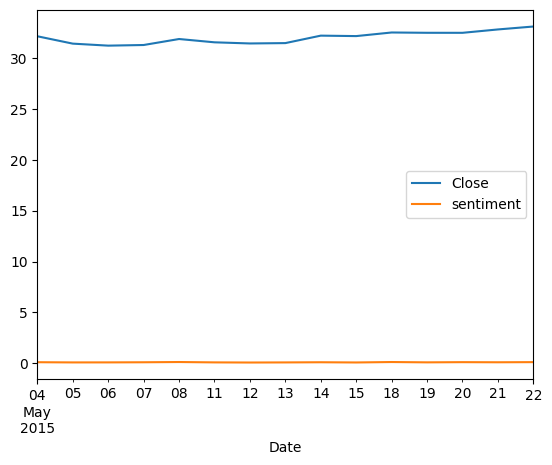

In [23]:
# Excluir todas as linhas com valores ausentes em qualquer coluna
merged.dropna(inplace=True)
#Agora vamos tentar representar graficamente nosso gráfico:
merged.plot()

In [24]:
# dimensiona as colunas por pontuações z usando StandardScaler
# Instância do StandardScaler para realizar a padronização dos dados.
s = StandardScaler()

<Axes: >

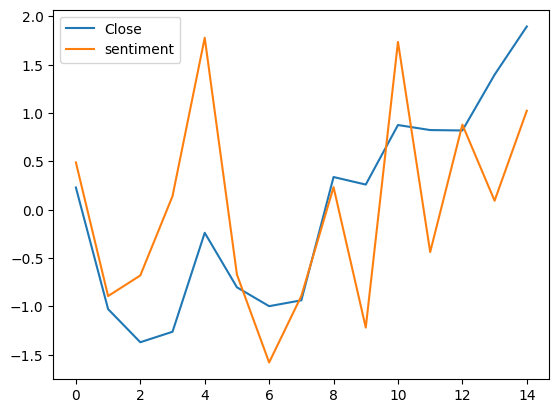

In [25]:
#Aplica a transformação de padronização aos dados do Df merged
merged_scaled = s.fit_transform(merged)
pd.DataFrame(merged_scaled, columns=merged.columns).plot()

Muito melhor! O preço de fechamento da ação realmente parece se mover com o sentimento de "mercado".

Vamos tentar aplicar um modelo de aprendizado supervisionado.

Para que isso funcione, precisamos definir nossos recursos e nossa resposta.

*   Nossa resposta é o valor que desejamos prever
*   Nossos recursos são valores que usaremos para prever a resposta.

Se olharmos para cada linha de nossos dados, temos um sentimento e um preço de fechamento para aquele dia. No entanto, queremos usar o sentimento de hoje para prever o preço das ações de amanhã e se ele aumentou ou não.

Pense nisso; seria uma espécie de trapaça porque o sentimento de hoje incluirá tweets após o preço de fechamento ter sido finalizado. Para simplificar, vamos ignorar qualquer tweet como um recurso para a previsão do preço de hoje.

Portanto, para cada linha, nossa resposta deve ser o preço de fechamento de hoje, enquanto nosso recurso deve ser o sentimento da ação de ontem. Para fazer isso, usarei uma função interna do Pandas chamada shift para deslocar nossa coluna de sentimento um item para trás:

In [26]:
# Desloca a coluna de sentimento um item para trás
merged['yesterday_sentiment'] = merged['sentiment'].shift(1)
merged.head()

,Close,sentiment,yesterday_sentiment
Date,,,
2015-05-04,32.174999,0.084062,NaN
2015-05-05,31.450001,0.063895,0.084062
2015-05-06,31.252501,0.067004,0.063895
2015-05-07,31.315001,0.078972,0.067004
2015-05-08,31.905001,0.102869,0.078972


Ah bom, agora para cada dia temos nossa verdadeira característica, que é o sentimento de ontem. Observe que em nossa cabeça (primeiras cinco linhas) temos um novo valor nulo! Isso ocorre porque no primeiro dia não temos um valor de ontem, então teremos que removê-lo. Mas antes, vamos definir nossa coluna de resposta. Temos duas opções:


*   Manter nossa resposta quantitativa e usar uma análise de regressão
*   Converter nossa resposta em um estado qualitativo e usar a classificação Qual rota escolher depende do cientista de dados e depende da situação.

Se você deseja apenas associar o sentimento a um movimento no preço, recomendo usar a rota de classificação. Se você deseja associar o sentimento à quantidade de movimento, recomendo uma regressão.

Faremos as duas para esse exercício:

#Regressão
Temos nossa resposta e nosso único recurso. Primeiro teremos que remover aquele valor nulo antes de continuar

In [27]:
# Faça um novo dataframe para nossa regressão e descarte os valores nulos
regression_df = merged[['yesterday_sentiment', 'Close']]
regression_df.dropna(inplace=True)
regression_df.head()

,yesterday_sentiment,Close
Date,,
2015-05-05,0.084062,31.450001
2015-05-06,0.063895,31.252501
2015-05-07,0.067004,31.315001
2015-05-08,0.078972,31.905001
2015-05-11,0.102869,31.580000


In [28]:
#Vamos usar uma floresta aleatória 'RandomForestRegressor' e uma regressão linear e ver qual funciona melhor, usando RMSE como nossa métrica:
# Importações para nossa regressão
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

# Usaremos um RMSE de validação cruzada para comparar nossos dois modelos:


*   O RMSE é uma medida comumente usada para avaliar a precisão de um modelo de regressão



In [29]:
# Nosso RMSE como resultado da regressão linear de validação cruzada
linreg = LinearRegression()
rmse_cv = np.sqrt(abs(cross_val_score(linreg, regression_df[['yesterday_sentiment']],
                                      regression_df['Close'], cv=3, scoring=
                                      'neg_mean_squared_error').mean()))
rmse_cv

0.8765180345824446

In [30]:
# Nosso RMSE como resultado da floresta aleatória de validação cruzada
rf = RandomForestRegressor()
rmse_cv = np.sqrt(abs(cross_val_score(rf, regression_df[['yesterday_sentiment']],
                                      regression_df['Close'], cv=3,scoring=
                                      'neg_mean_squared_error').mean()))
rmse_cv

0.8874827083163694

Olhe para o nosso RMSE, é cerca de 0,87 para ambos os modelos, o que significa que, em média, nosso modelo está errado em cerca de 0,87 dólares, o que é realmente um grande negócio, considerando que o preço de nossas ações provavelmente não muda tanto:

In [31]:
regression_df['Close'].describe()

count    14.000000
mean     32.033215
std       0.617953
min      31.252501
25%      31.476251
50%      32.048751
75%      32.516876
max      33.134998
Name: Close, dtype: float64

Outra forma de testar a validade do nosso modelo é comparando nosso RMSE com o RMSE do modelo nulo. O modelo nulo para um modelo de regressão está prevendo o valor médio para cada valor:

In [32]:
# modelo nulo para regressão
mean_close = regression_df['Close'].mean()
preds = [mean_close]*regression_df.shape[0]
null_rmse = np.sqrt(mean_squared_error(preds, regression_df['Close']))
null_rmse

0.595473959497161

Como nosso modelo não superou o modelo nulo, talvez a regressão não seja o melhor caminho a seguir

#Classificação

Para classificação, temos um pouco mais de trabalho a fazer porque ainda não temos uma resposta categórica. Para fazer um, precisamos transformar a coluna de fechamento em alguma opção categórica. Vou optar por fazer a seguinte resposta. Farei uma nova coluna chamada change_close_big_deal, definida da seguinte forma:

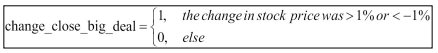

Portanto, nossa resposta será 1 se nossa resposta mudou muito e 0 se a mudança
em estoque era insignificante:

In [33]:
# Importações para nossa classificação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Faça um novo dataframe para nossa classificação e descarte os valores nulos
classification_df = merged[['yesterday_sentiment', 'Close']]

# variável para representar o preço de fechamento de ontem
classification_df['yesterday_close'] = classification_df['Close'].shift(1)

# coluna que representa a variação anterior no preço desde ontem
classification_df['percent_change_in_price'] = (classification_df['Close']-
                                                classification_df['yesterday_close'])/classification_df['yesterday_close']

# descarta quaisquer valores nulos
classification_df.dropna(inplace=True)
classification_df.head()

,yesterday_sentiment,Close,yesterday_close,percent_change_in_price
Date,,,,
2015-05-05,0.084062,31.450001,32.174999,-0.022533
2015-05-06,0.063895,31.252501,31.450001,-0.006280
2015-05-07,0.067004,31.315001,31.252501,0.002000
2015-05-08,0.078972,31.905001,31.315001,0.018841
2015-05-11,0.102869,31.580000,31.905001,-0.010187


In [34]:
# Nossa nova resposta de classificação
classification_df['change_close_big_deal'] = abs(classification_df['percent_change_in_price'] ) > .01
classification_df.head()

,yesterday_sentiment,Close,yesterday_close,percent_change_in_price,change_close_big_deal
Date,,,,,
2015-05-05,0.084062,31.450001,32.174999,-0.022533,True
2015-05-06,0.063895,31.252501,31.450001,-0.006280,False
2015-05-07,0.067004,31.315001,31.252501,0.002000,False
2015-05-08,0.078972,31.905001,31.315001,0.018841,True
2015-05-11,0.102869,31.580000,31.905001,-0.010187,True


Vamos agora realizar a mesma validação cruzada que fizemos com nossa regressão, desta vez usaremos o recurso de precisão do nosso módulo de validação cruzada e, em vez de um módulo de regressão, usaremos dois algoritmos de aprendizado de máquina de classificação:

In [35]:
# Nossa precisão como resultado da RF de validação cruzada
rf = RandomForestClassifier()
accuracy_cv = cross_val_score(rf, classification_df[['yesterday_sentiment']],
                              classification_df['change_close_big_deal'],cv=3,
                              scoring='accuracy').mean()
accuracy_cv

0.2333333333333333

Não tão bom, vamos tentar a regressão logística:

In [36]:
# Nossa precisão como resultado da regressão logística de validação cruzada
logreg = LogisticRegression()
accuracy_cv = cross_val_score(logreg,classification_df[['yesterday_sentiment']],
                              classification_df['change_close_big_deal'], cv=3,
                              scoring='accuracy').mean()
accuracy_cv

0.5666666666666667

Melhor, mas é claro que devemos verificar com a precisão do nosso modelo nulo:

In [37]:
# modelo nulo para classificação
null_accuracy = 1 - classification_df['change_close_big_deal'].mean()
null_accuracy

0.5714285714285714

Maravilha, nosso modelo pode superar a precisão nula, o que significa que nosso algoritmo de aprendizado de máquina pode prever o movimento do preço de uma ação usando o sentimento da mídia social melhor do que apenas adivinhar aleatoriamente!

## Indo além com este exemplo
Há muitas maneiras de aprimorar este exemplo para fazer uma previsão mais robusta. Poderíamos ter incluído mais recursos, incluindo uma média móvel de sentimento, em vez de olhar simplesmente para o sentimento do dia anterior. Também poderíamos ter trazido mais exemplos para aprimorar nossa ideia de sentimento. Poderíamos ter consultado o Facebook, a mídia e assim por diante para obter mais informações sobre como acreditamos que a ação se comportará no futuro. Na verdade, tínhamos apenas 14 pontos de dados, o que está longe de ser suficiente para criar um algoritmo pronto para produção. É claro que para os propósitos de um simples exercício é suficiente, mas se quisermos fazer um algoritmo financeiro que possa efetivamente prever o movimento do preço das ações, teremos que obter muito mais dias de mídia e preços.